In [75]:
import datetime  # For datetime objects
import pandas as pd  # For data manipulation
import numpy as np

import yfinance as yf # for finance data

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

import backtrader as bt

In [86]:
df = yf.download('MDB', start='2020-1-1', end='2022-1-1')
df.columns = df.columns.droplevel('Ticker')
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,134.330002,134.669998,126.080002,130.179993,1166900
2020-01-03,135.289993,136.220001,131.759995,132.429993,598300
2020-01-06,140.500000,140.889999,132.705002,132.880005,1254600
2020-01-07,138.860001,142.610001,138.250000,140.500000,672000
2020-01-08,140.270004,141.639999,136.229996,138.899994,978800
...,...,...,...,...,...
2021-12-27,559.190002,570.580017,551.349976,552.000000,346200
2021-12-28,542.080017,563.987976,541.080017,563.330017,395000
2021-12-29,538.010010,541.210022,528.859985,539.719971,479200


In [87]:
class MomentumStrategy(bt.Strategy):
    params = dict(period=90)  # look‑back period
    # simply prints
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):

        # close price
        self.dataclose = self.datas[0].close
        # open price
        self.dataopen = self.datas[0].open

        # momentum = close / close(period ago)
        self.mom = self.data.close / self.data.close(-self.p.period)

        # track pending orders
        self.order = None

        # track when enter pos
        self.bar_executed = 0

    # tracking when the order is executed
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # check order pending
        if self.order:
            return

        # check in market
        if not self.position:
            if self.mom[0] > 1:       # entry: momentum > 1
                self.order = self.buy()
                self.log('BUY CREATE, %.2f')

        else:
            bars_held = len(self) - self.bar_executed
            # exit: momentum ≤ 1 or been in market for 10 days
            if self.mom[0] <= 1 or len(self) >= (self.bar_executed + 10):
                self.log('SELL CREATE, %.2f')
                self.order = self.sell()


In [88]:
cerebro = bt.Cerebro()

cerebro.addstrategy(MomentumStrategy, period=90)

datafeed = bt.feeds.PandasData(dataname=df)
cerebro.adddata(datafeed)

cerebro.broker.setcash(1000)

cerebro.broker.setcommission(commission=0.005)

cerebro.addsizer(bt.sizers.PercentSizer, percents=20)

cerebro.addanalyzer(bt.analyzers.SharpeRatio,
                    _name='sharpe',
                    timeframe=bt.TimeFrame.Days,
                    annualize=True,
                    riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annualreturn')

print('Starting Portfolio Value:', cerebro.broker.getvalue())

results = cerebro.run()
strat = results[0]

print('Final Portfolio Value  :', cerebro.broker.getvalue())

print(f"\nSharpe Ratio: {strat.analyzers.sharpe.get_analysis().get('sharperatio', None):.3f}")
print(f"Max Drawdown: {strat.analyzers.drawdown.get_analysis()['max']['drawdown']:.3f}")
print(f"Compound Annual Growth Rate (CAGR): {(cerebro.broker.getvalue() /1000) ** (1/2) - 1:.2%}")

Starting Portfolio Value: 1000
2020-05-12, Close, 193.00
2020-05-12, BUY CREATE, %.2f
2020-05-13, BUY EXECUTED, 194.47
2020-05-13, Close, 194.11
2020-05-14, Close, 194.32
2020-05-15, Close, 196.28
2020-05-18, Close, 194.17
2020-05-19, Close, 200.22
2020-05-20, Close, 206.62
2020-05-21, Close, 208.92
2020-05-22, Close, 220.28
2020-05-26, Close, 216.46
2020-05-27, Close, 211.89
2020-05-28, Close, 215.60
2020-05-28, SELL CREATE, %.2f
2020-05-29, SELL EXECUTED, 217.77
2020-05-29, Close, 232.11
2020-05-29, BUY CREATE, %.2f
2020-06-01, BUY EXECUTED, 229.02
2020-06-01, Close, 238.38
2020-06-02, Close, 234.92
2020-06-03, Close, 233.96
2020-06-04, Close, 220.04
2020-06-05, Close, 197.98
2020-06-08, Close, 203.88
2020-06-09, Close, 201.70
2020-06-10, Close, 208.18
2020-06-11, Close, 196.84
2020-06-12, Close, 193.67
2020-06-15, Close, 201.74
2020-06-15, SELL CREATE, %.2f
2020-06-16, SELL EXECUTED, 203.44
2020-06-16, Close, 203.75
2020-06-16, BUY CREATE, %.2f
2020-06-17, BUY EXECUTED, 205.47
2020-

<IPython.core.display.Javascript object>

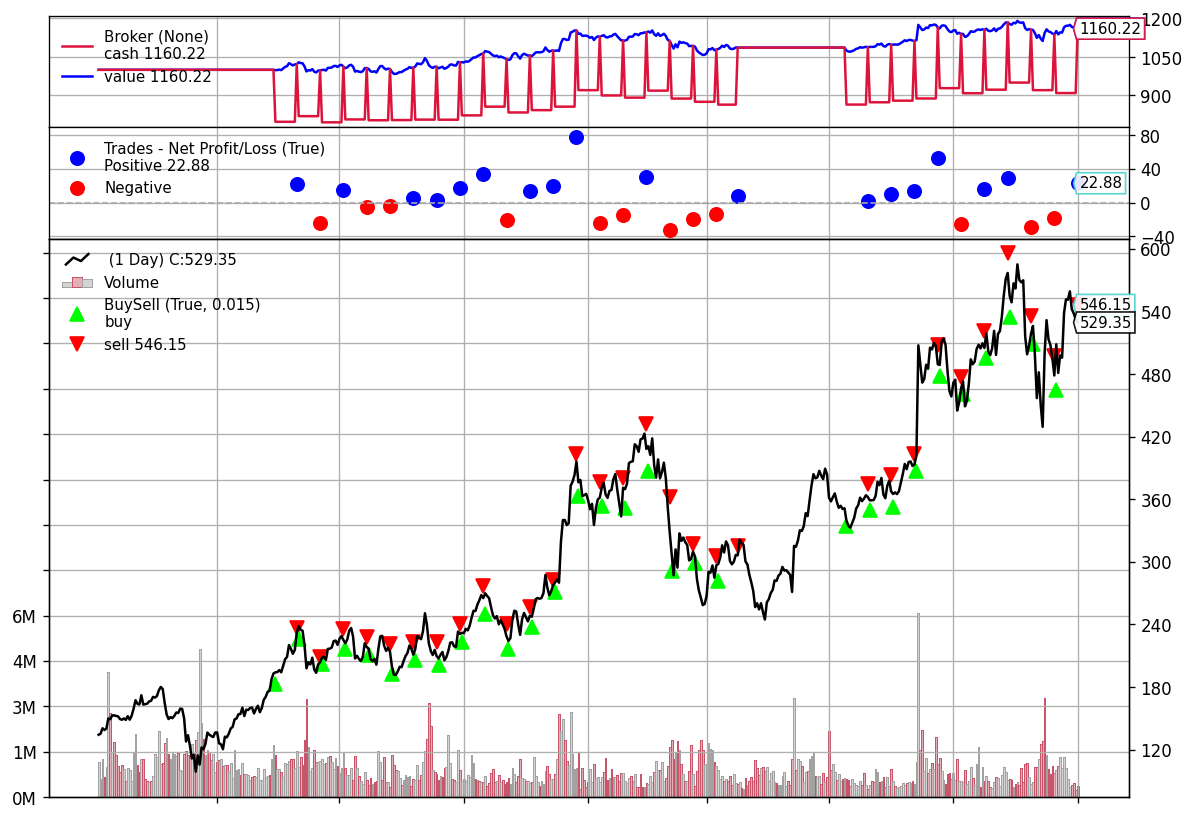

In [89]:
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['figure.dpi'] = 120
figs = cerebro.plot()
for figlist in figs:
    for f in figlist:
        display(f)